In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model

mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti, compute capability 8.6
2.8.0-rc1


In [2]:
# Load data
df = pd.read_csv('kaggle/input/ubiquant-market-prediction/train.csv', engine='pyarrow')
investment_ids = list(range(max(df['investment_id'].to_list())+1))
# investment_timesteps_count = [len(df.loc[df['investment_id'].values == i]) for i in investment_ids]
# print(f'Longest ID: {investment_ids[investment_timesteps_count.index(max(investment_timesteps_count))]}')
split_investments = []
for i in investment_ids:
    investment = df.loc[df['investment_id'].values == i]
    if not investment.empty:
        split_investments.append(investment)
train = split_investments[:int(len(split_investments)*0.8)]
val = split_investments[int(len(split_investments)*0.8):]
print(f'Total valid investments: {len(split_investments)}, train/val split: {len(train)}/{len(val)}')

Total valid investments: 2329, train/val split: 1863/466


In [3]:
# Pearson correlation coefficient loss and metrics
def pearson_corr(x, y, axis=-1):
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.math.abs(corr)  # by right should not be abs but in this case we just want the line to fit so it doesnt matter if its going up or down


def pearson_corr_loss(x, y, axis=-1):
    return 1 - pearson_corr(x, y, axis=axis)


# y_true = tf.cast(split_investments[0]['target'].to_numpy(), dtype=tf.float16)
#
# # t1,t2 = tf.constant([[1.], [2.], [3.], [4.], [5.]]), tf.constant([[10.], [9.], [2.5], [6.], [4.]])
# print(pearson_corr(y_true, y_pred, axis=-2))
# print(pearson_corr_loss(y_true, y_pred, axis=-2))
#
# from scipy.stats import pearsonr
# pearsonr(y_true.numpy(), y_pred.numpy())[0]  # should be same as pearson_corr
#
# y_true.numpy()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 300)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         219648    
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         394240    
                                                                 
 layer_normalization (LayerN  (None, None, 256)        512       
 ormalization)                                                   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 256)        0         
 ropout1D)                                                       
                                                                 
 lstm_2 (LSTM)               (None, None, 512)         157491

C:\Program Files\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


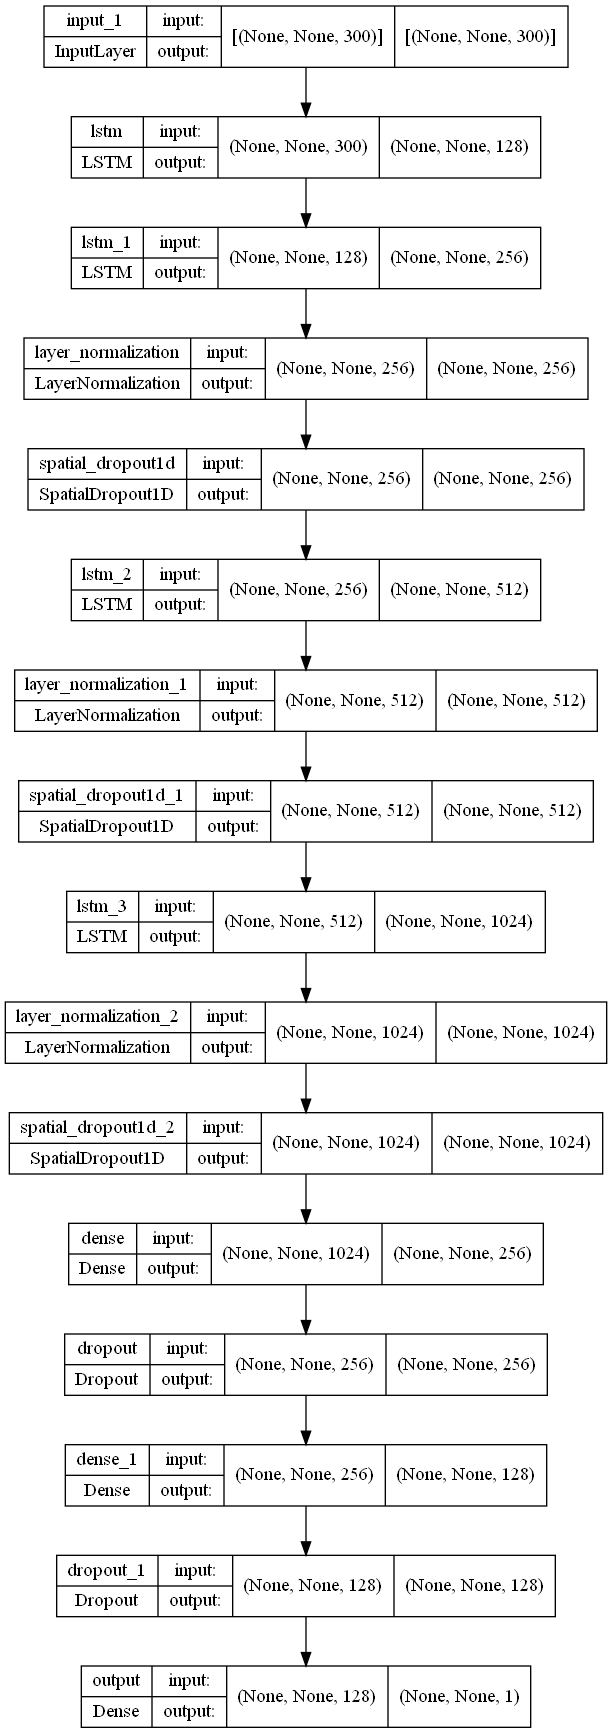

In [4]:
# Model
xIn = Input(shape=(None, 300))  # f0 to f299 = 300 features
# xScaled = Lambda(lambda x: tf.math.multiply(x, 100), name='upscaler')(xIn)  # upscale to improve numerical stability
x = LSTM(128, return_sequences=True)(xIn)
x = LSTM(256, return_sequences=True)(x)
x = LayerNormalization()(x)
x = SpatialDropout1D(0.2)(x)
x = LSTM(512, return_sequences=True)(x)
x = LayerNormalization()(x)
x = SpatialDropout1D(0.2)(x)
# x = LSTM(1024, return_sequences=True)(x)
# x = concatenate([x, xIn])
x = LSTM(1024, return_sequences=True)(x)
x = LayerNormalization()(x)
x = SpatialDropout1D(0.2)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
xOut = Dense(1, name='output')(x)


model = Model(inputs=xIn, outputs=xOut)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-3), metrics=[pearson_corr, 'mse'])
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

In [6]:
# Train
valx = tf.expand_dims(val[0].loc[:, 'f_0':'f_299'].to_numpy(), axis=0)
valy = tf.expand_dims(val[0]['target'].to_numpy(), axis=0)
epoch = 10
print('Training...')
for i in range(epoch):
    print(f'Epoch {i+1}/{epoch}')
    for inv in train:
        x = tf.expand_dims(inv.loc[:, 'f_0':'f_299'].to_numpy(), axis=0)
        y = tf.expand_dims(inv['target'].to_numpy(), axis=0)
        model.fit(x, y, validation_data=(valx, valy), epochs=1, batch_size=16, verbose=0)

print('Evaluating...')
eval_result = []
for inv in val:
    x = tf.expand_dims(inv.loc[:, 'f_0':'f_299'].to_numpy(), axis=0)
    y = tf.expand_dims(inv['target'].to_numpy(), axis=0)
    eval_result.append(model.evaluate(x, y, verbose=1))

# y_pred = model.predict(valx)

Training...
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Evaluating...
1/1 [==============================] - 0s 22ms/step - loss: 0.2820 - pearson_corr: 0.5914 - mse: 0.2819


In [8]:
import statistics
print(f'Mean: {statistics.mean([i[0] for i in eval_result])}')
model.save('mean val 0.91947')

Mean: 0.9194695796066088


INFO:tensorflow:Assets written to: mean val 0.91947\assets


INFO:tensorflow:Assets written to: mean val 0.91947\assets


In [9]:
from ubiquantEmulator import TimeSeriesAPI
model = load_model('mean val 0.91947', custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss})
test = pd.read_csv('kaggle/input/ubiquant-market-prediction/train.csv', engine='pyarrow')
iter_train = TimeSeriesAPI(test[test["investment_id"] < 100][:100])
for n, (train_df, sample_prediction_df) in enumerate(iter_train):
    pred = []
    for index, row in train_df.iterrows():
        print(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(np.asarray(row.loc['f_0':'f_299']).astype('float32'), axis=0), axis=0))).numpy())
        pred += [tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(np.asarray(row.loc['f_0':'f_299']).astype('float32'), axis=0), axis=0))).numpy()]
    # make inference
    sample_prediction_df.assign(target=pd.Series(pred))
    iter_train.predict(sample_prediction_df)

-0.0646
-0.632
0.4907
-0.1924
-0.1254
-0.11597
-0.6357
-0.2153
-0.1145
-0.3435
0.3418
-0.3535
0.1617
-0.2141
-0.6606
-0.574
-0.637
0.138
0.172
0.3013
0.4978
-0.6377
0.367
0.3223
-0.1365
-0.0902
-0.342
-0.1028
-0.1978
0.1693
-0.217
-0.0913
0.435
0.08386
0.4736
-0.0491
0.4697
-0.077
0.137
0.4329
-0.3308
0.1011
-0.4294
0.449
-0.287
0.051
-0.2878
0.184
-0.6533
-0.6216
0.08954
-0.265
-0.451
-0.5923
0.4758
0.1189
-0.6626
0.1415
0.1377
-0.0842
-0.3054
0.4705
-0.2969
-0.01694
-0.1477
-0.3967
0.06647
0.1477
-0.06604
0.3274
0.0934
0.1682
-0.0718
-0.6455
-0.617
-0.309
0.1392
-0.00821
0.4717
0.2883
0.1309
0.11804
0.4087
-0.1796
-0.1877
0.05518
-0.067
0.1764
0.1388
0.1442
0.4038
-0.03915
0.4734
-0.10046
0.471
-0.005585
0.02429
0.4697
-0.0757
0.4463


In [ ]:
import ubiquant
env = ubiquant.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission
for (test_df, sample_prediction_df) in iter_test:
    sample_prediction_df['target'] = 0  # make your predictions here
    env.predict(sample_prediction_df)   # register your predictions